In [44]:
!nvidia-smi

Mon Apr 24 12:16:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    52W / 400W |  14957MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
import torch.nn.functional as F
import os
device='cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
trans=transforms.Compose([
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.GaussianBlur(kernel_size=3, sigma=0.1),
    torchvision.transforms.ColorJitter(0.2,0.2,0.2)
])

In [47]:
print(device)

cuda


In [48]:
from sklearn.model_selection import train_test_split
train_data=os.listdir("/content/drive/MyDrive/DL_project/TRAIN")
train_data.sort()
train_data_2=[0,0,0,0,0]
train_data_2[0]=train_data[1]
train_data_2[1]=train_data[2]
train_data_2[2]=train_data[0]
train_data_2[3]=train_data[4]
train_data_2[4]=train_data[3]
all_paths=[]
all_labels=[]
for i,path in enumerate(train_data_2):
    full_path="/content/drive/MyDrive/DL_project/TRAIN/"+path+"/"
    lst=os.listdir(full_path)
    lst=[full_path+i for i in lst]
    all_paths.extend(lst)
    all_labels.extend([i for j in range(len(lst))])
all_paths=np.array(all_paths)
all_labels=np.array(all_labels)
train_lst,val_lst,train_labels,val_labels=train_test_split(all_paths,all_labels,test_size=0.2)

In [49]:
!pip install transformers
!pip install sentense-piece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sentense-piece (from versions: none)
ERROR: No matching distribution found for sentense-piece


In [22]:
class DataSet(Dataset):
    def __init__(self,paths,labels,transform=None):
        self.transform=transform
        self.images_path=paths
        self.labels=labels
        self.transform_norm=transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225))
        if(transform is not None):
            self.images_path=np.append(self.images_path,self.images_path)
            self.labels=np.append(self.labels,self.labels)
    def __len__(self):
        return len(self.images_path)
    def __getitem__(self,idx):
        hf=len(self.images_path)/2
        img=self.images_path[idx]
        image=cv2.imread(img)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image,(312,312), interpolation=cv2.INTER_CUBIC)
        resized_image=np.array(resized_image)
        resized_image=resized_image[44:268,44:268,:]
        resized_image=torch.tensor(resized_image).to(torch.float32)
        if(self.transform is not None):
            half=len(self.images_path)/2
            if(idx>=half):
                resized_image=torch.reshape(resized_image,(3,224,224))
                resized_image=self.transform(resized_image)
                return resized_image,self.labels[idx]
            
        resized_image=torch.reshape(resized_image,(3,224,224))
        resized_image=self.transform_norm(resized_image)
        return resized_image,self.labels[idx]

In [50]:
from transformers import AutoFeatureExtractor
class DataSet2(Dataset):
    def __init__(self,paths,labels,transform=None):
        self.transform=transform
        self.images_path=paths
        self.labels=labels
        self.transform_norm=transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225))
        if(transform is not None):
            self.images_path=np.append(self.images_path,self.images_path)
            self.labels=np.append(self.labels,self.labels)
    def __len__(self):
        return len(self.images_path)
    def __getitem__(self,idx):
        hf=len(self.images_path)/2
        img=self.images_path[idx]
        image=cv2.imread(img)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image,(224,224), interpolation=cv2.INTER_CUBIC)
        resized_image=AutoFeatureExtractor.from_pretrained("martinezomg/vit-base-patch16-224-diabetic-retinopathy")(resized_image).pixel_values
        resized_image=np.array(resized_image)
        resized_image=torch.tensor(resized_image).to(torch.float32)
        if(self.transform is not None):
            half=len(self.images_path)/2
            if(idx>=half):
                resized_image=torch.reshape(resized_image,(3,224,224))
                resized_image=self.transform(resized_image)
                return resized_image,self.labels[idx]
            
        resized_image=torch.reshape(resized_image,(3,224,224))
        resized_image=self.transform_norm(resized_image)
        return resized_image,self.labels[idx]

In [51]:
train_dataset=DataSet2(train_lst,train_labels,trans)
val_dataset=DataSet2(val_lst,val_labels,trans)
train_loader=DataLoader(train_dataset,batch_size=12,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=12,shuffle=True)

In [9]:
img,lab=next(iter(train_loader))
print(img.shape)
print(lab)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


torch.Size([12, 3, 224, 224])
tensor([2, 4, 4, 2, 3, 3, 0, 4, 0, 2, 2, 3])


In [73]:
import warnings
warnings.filterwarnings("ignore")
import torchvision
from transformers import AutoFeatureExtractor, AutoModelForImageClassification,ViTForImageClassification
class VIT(nn.Module):
  def __init__(self):
    super().__init__()
    #self.extractor=AutoFeatureExtractor.from_pretrained("martinezomg/vit-base-patch16-224-diabetic-retinopathy")
  def forward(self,x):
    x=x.to(device)
    x=x.to(torch.float32)
    x=self.model(x).logits
    x=self.l1(x)
    return x
class encoder3(nn.Module):
  def __init__(self,mod):
    super().__init__()
    self.weights=torch.normal(0,1,size=[1,1,mod],dtype=torch.float32).to(device)
    self.weights.requires_grad=True
    self.weights.Trainable=True
    self.weights.grad=torch.zeros([1,1,mod],dtype=torch.float32).to(device)
  def forward(self,x):
    with torch.no_grad():
      if(self.weights.grad is not None):
        self.weights -= self.weights.grad * 0.2
        self.weights.grad.zero_()
    e=x*self.weights
    e=torch.sum(e,dim=2)
    e=torch.tanh(e)
    a=F.softmax(e,dim=1)
    #a=torch.reshape(a,(a.shape[0],a.shape[1],1))
    return a
class Attention(nn.Module):
  def __init__(self):
    super().__init__()
    self.res=self.res=torchvision.models.resnet50(pretrained=True).to(device)
    modules=list(self.res.children())[:-3]
    self.res=nn.Sequential(*modules)
    
    for param in self.res.parameters():
      param.Trainable=False
      param.dropout=0.3
    
    self.stack1=nn.Conv2d(1024,256,(1,1)).to(device)
    self.stack2=nn.Conv2d(1024,256,(3,3),padding=1).to(device)
    self.stack3=nn.Conv2d(1024,256,(5,5),padding=2).to(device)
    self.stack4=nn.Conv2d(1024,256,(7,7),padding=3).to(device)

    torch.nn.init.xavier_uniform(self.stack1.weight)
    torch.nn.init.xavier_uniform(self.stack2.weight)
    torch.nn.init.xavier_uniform(self.stack3.weight)
    torch.nn.init.xavier_uniform(self.stack4.weight)

    self.lstm=nn.LSTM(14*14,128,batch_first=True,bidirectional=True).to(device)
    for param in self.lstm.parameters():
      param.dropout=0.3
    self.encoder=encoder3(256).to(device)
    for p in self.encoder.parameters():
      p.Trainable=True

    self.classifier=nn.Sequential(
        nn.Conv2d(1024,1024,(5,5)).to(device),
        nn.MaxPool2d((3,3)).to(device),
        nn.Conv2d(1024,1024,(3,3)).to(device),
        nn.Flatten(),
        nn.Linear(1024,100).to(device),
        nn.Linear(100,5).to(device)
    ).to(device)
    #torch.nn.init.xavier_uniform(self.classifier.weight)

    for param in self.classifier.parameters():
      param.dropout=0.3

    self.model=ViTForImageClassification.from_pretrained("martinezomg/vit-base-patch16-224-diabetic-retinopathy").to(device)
    for param in self.model.parameters():
      param.Trainable=False
      param.dropout=0.3

    self.l1=nn.Linear(4,5).to(device)
    torch.nn.init.xavier_uniform(self.l1.weight)
  def forward(self,x):
    x= x.to(torch.float32)
    x=x.to(device)
    x1=self.model(x).logits
    #x1=self.l1(x1)
    x=self.res(x)
    st1=self.stack1(x)
    st2=self.stack2(x)
    st3=self.stack3(x)
    st4=self.stack4(x)
    x=torch.concatenate([st1,st2,st3,st4],dim=1)
    x_tx=torch.reshape(x,(x.shape[0],-1,x.shape[2]*x.shape[3]))
    x_tx=self.lstm(x_tx)
    x_tx=x_tx[0]
    a=self.encoder(x_tx)
    x=x*a.view(a.shape[0],a.shape[1], 1, 1)
    x=self.classifier(x)
    x=x1+x
    return x

In [53]:
from sklearn.metrics import accuracy_score,precision_score,f1_score
def get_acc(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return accuracy_score(arr,arr2)
def get_prec(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return precision_score(arr,arr2,average='macro')
def get_f1(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return f1_score(arr,arr2,average='macro')

In [74]:
from tqdm import tqdm
def train(model,train_dataloader,epochs,optimizer,criterion,val_loader):
    tr_acc_l=[]
    tr_loss_l=[]
    tr_prec_l=[]
    tr_f1_l=[]
    val_acc_l=[]
    val_prec_l=[]
    val_f1_l=[]
    val_loss_l=[]
    for ep in range(epochs):  
        model.train()
        running_loss = 0.0
        tr_acc=0
        tr_prec=0
        tr_f1=0
        for i,data in tqdm(enumerate(train_dataloader)):
            inputs, labels = data
            optimizer.zero_grad()
            imputs=inputs.to(device)
            outputs = model(inputs)
            outputs=outputs.to('cpu')
            labels=labels.to(torch.long)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            outputs=torch.argmax(outputs,dim=1)
            tr_acc+=get_acc(outputs,labels)
            tr_prec+=get_prec(outputs,labels)
            tr_f1+=get_f1(outputs,labels)
            if(i%25==0):
                sen = f"Training Epochs:{ep} Mini Batch {i+1},Running Loss {running_loss/(i+1)} ,Accuracy:{tr_acc/(i+1)},Precision:{tr_prec/(i+1)},F1:{tr_f1/(i+1)}"
                print(sen)
        running_loss/=(i+1)
        tr_acc=tr_acc/(i+1)
        tr_prec=tr_prec/(i+1)
        tr_f1=tr_f1/(i+1)
        sen = f"Training Epochs:{ep},Running Loss {running_loss} ,Accuracy:{tr_acc},Precision:{tr_prec},F1:{tr_f1}"
        print(sen)
        tr_acc_l.append(tr_acc)
        tr_prec_l.append(tr_prec)
        tr_f1_l.append(tr_f1)
        tr_loss_l.append(running_loss)
        model.eval()
        with torch.no_grad():
            total_loss = 0
            val_acc=0
            val_prec=0
            val_f1=0
            for i,(inputs, targets) in tqdm(enumerate(val_loader)):
                inputs=inputs.to(device)
                outputs = model(inputs)
                targets=targets.to(torch.long)
                targets=targets.to('cpu')
                outputs=outputs.to('cpu')
                loss = criterion(outputs, targets)
                total_loss += loss.item()
                outputs=torch.argmax(outputs,dim=1)
                val_acc+=get_acc(outputs,targets)
                val_prec+=get_prec(outputs,targets)
                val_f1+=get_f1(outputs,targets)
                if(i%25==0):
                    sen = f"Validation Epochs:{ep} Mini Batch {i+1},Running Loss {total_loss/(i+1)} ,Accuracy:{val_acc/(i+1)},Precision:{val_prec/(i+1)},F1:{val_f1/(i+1)}"
                    print(sen)
            val_acc/=(i+1)
            total_loss/=(i+1)
            val_prec/=(i+1)
            val_f1/=(i+1)
            sen = f"Validation Epochs:{ep},Running Loss {total_loss} ,Accuracy:{val_acc},Precision:{val_prec},F1:{val_f1}"
            print(sen)
            val_acc_l.append(val_acc)
            val_prec_l.append(val_prec)
            val_f1_l.append(val_f1)
            val_loss_l.append(total_loss)
    return tr_acc_l,tr_prec_l,tr_f1_l,tr_loss_l,val_acc_l,val_prec_l,val_f1_l,val_loss_l       

In [75]:
import torch.optim as optim
model=Attention()
criterion = nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(),lr=0.00002)

In [76]:
print(model.model.config.id2label[0])
print(model.model.config.id2label[1])
print(model.model.config.id2label[2])
print(model.model.config.id2label[3])
print(model.model.config.id2label[4])

leve
moderado
no dr
proliferativa
severa


In [77]:
tr_acc_l,tr_prec_l,tr_f1_l,tr_loss_l,val_acc_l,val_prec_l,val_f1_l,val_loss_l=train(model,
                                                                                    train_loader,
                                                                                    3,
                                                                                    optim,
                                                                                    criterion,
                                                                                    val_loader)      


1it [00:07,  7.24s/it]

Training Epochs:0 Mini Batch 1,Running Loss 1.572135090827942 ,Accuracy:0.4166666666666667,Precision:0.25,F1:0.14705882352941177


26it [03:06,  7.13s/it]

Training Epochs:0 Mini Batch 26,Running Loss 1.4959105986815233 ,Accuracy:0.36538461538461536,Precision:0.32005494505494503,F1:0.264313888307101


51it [06:05,  7.04s/it]

Training Epochs:0 Mini Batch 51,Running Loss 1.4060796440816392 ,Accuracy:0.39869281045751637,Precision:0.3329271708683473,F1:0.28198000565662806


76it [09:05,  7.17s/it]

Training Epochs:0 Mini Batch 76,Running Loss 1.3561629888258482 ,Accuracy:0.41885964912280704,Precision:0.35021720969089376,F1:0.29742152018284496


101it [12:08,  7.19s/it]

Training Epochs:0 Mini Batch 101,Running Loss 1.344426934671874 ,Accuracy:0.4216171617161717,Precision:0.3503069830792602,F1:0.29548524756307604


111it [13:14,  7.16s/it]


Training Epochs:0,Running Loss 1.3215612731538378 ,Accuracy:0.43243243243243257,Precision:0.35749189665856324,F1:0.30303183249003673


1it [00:07,  7.33s/it]

Validation Epochs:0 Mini Batch 1,Running Loss 1.5008560419082642 ,Accuracy:0.25,Precision:0.125,F1:0.11538461538461538


26it [03:08,  7.29s/it]

Validation Epochs:0 Mini Batch 26,Running Loss 1.2795059726788447 ,Accuracy:0.46153846153846156,Precision:0.41648046398046384,F1:0.32867088040164966


28it [03:20,  7.16s/it]


Validation Epochs:0,Running Loss 1.2617988969598497 ,Accuracy:0.4642857142857143,Precision:0.4188747165532879,F1:0.32657657818372104


1it [00:07,  7.05s/it]

Training Epochs:1 Mini Batch 1,Running Loss 1.3399723768234253 ,Accuracy:0.6666666666666666,Precision:0.5833333333333333,F1:0.5499999999999999


26it [03:05,  6.98s/it]

Training Epochs:1 Mini Batch 26,Running Loss 1.1216369718313217 ,Accuracy:0.5416666666666666,Precision:0.4604792429792429,F1:0.4037759035835959


51it [06:04,  7.16s/it]

Training Epochs:1 Mini Batch 51,Running Loss 1.0803589639710445 ,Accuracy:0.5457516339869279,Precision:0.4544825708061,F1:0.3973629801570977


76it [09:05,  7.08s/it]

Training Epochs:1 Mini Batch 76,Running Loss 1.0646009621651549 ,Accuracy:0.5405701754385964,Precision:0.44896720969089376,F1:0.40057726630095053


101it [12:05,  7.07s/it]

Training Epochs:1 Mini Batch 101,Running Loss 1.0702236073442024 ,Accuracy:0.5305280528052805,Precision:0.44376080465189355,F1:0.39039474002345287


111it [13:09,  7.11s/it]


Training Epochs:1,Running Loss 1.0611708569634068 ,Accuracy:0.5322822822822822,Precision:0.4441201916201914,F1:0.39415358915358917


1it [00:06,  6.96s/it]

Validation Epochs:1 Mini Batch 1,Running Loss 1.54867684841156 ,Accuracy:0.3333333333333333,Precision:0.36666666666666664,F1:0.3238095238095238


26it [03:13,  7.39s/it]

Validation Epochs:1 Mini Batch 26,Running Loss 1.1739796308370738 ,Accuracy:0.5256410256410257,Precision:0.45255494505494515,F1:0.41335608835608845


28it [03:25,  7.33s/it]


Validation Epochs:1,Running Loss 1.1954014429024287 ,Accuracy:0.5282738095238095,Precision:0.4508843537414967,F1:0.41636466707895287


1it [00:07,  7.56s/it]

Training Epochs:2 Mini Batch 1,Running Loss 0.5015796422958374 ,Accuracy:0.6666666666666666,Precision:0.4666666666666667,F1:0.4666666666666667


26it [03:05,  6.97s/it]

Training Epochs:2 Mini Batch 26,Running Loss 0.9587886001055057 ,Accuracy:0.5544871794871795,Precision:0.4757615995115995,F1:0.4238525576987116


51it [06:04,  7.16s/it]

Training Epochs:2 Mini Batch 51,Running Loss 0.9215105538274727 ,Accuracy:0.5784313725490197,Precision:0.49903205726735134,F1:0.45517396002690136


76it [09:03,  7.06s/it]

Training Epochs:2 Mini Batch 76,Running Loss 0.915289889432882 ,Accuracy:0.5910087719298246,Precision:0.5031333542188806,F1:0.46099960103249576


101it [12:01,  7.05s/it]

Training Epochs:2 Mini Batch 101,Running Loss 0.9234131660201762 ,Accuracy:0.5825082508250826,Precision:0.49839737545183105,F1:0.4565440399351291


111it [13:07,  7.09s/it]


Training Epochs:2,Running Loss 0.9228338451535852 ,Accuracy:0.5870870870870871,Precision:0.5058765908765911,F1:0.4644228152561487


1it [00:07,  7.09s/it]

Validation Epochs:2 Mini Batch 1,Running Loss 1.123131275177002 ,Accuracy:0.5833333333333334,Precision:0.5208333333333334,F1:0.4642857142857143


26it [03:08,  7.30s/it]

Validation Epochs:2 Mini Batch 26,Running Loss 1.097705215215683 ,Accuracy:0.5288461538461539,Precision:0.5104510073260072,F1:0.44888098013098016


28it [03:20,  7.16s/it]

Validation Epochs:2,Running Loss 1.1195352652243205 ,Accuracy:0.5208333333333334,Precision:0.5041985544217686,F1:0.4424514473621617


In [90]:
import pickle
def save_model(list_models,filename):
    pickle.dump(list_models, open(filename, 'wb'))
def load_model(filename):
    list_models=pickle.load(open(filename, 'rb'))
    return list_models
filename='/content/drive/MyDrive/DL_project/Models/Attention'
save_model(model,filename)

In [91]:
model=load_model(filename)

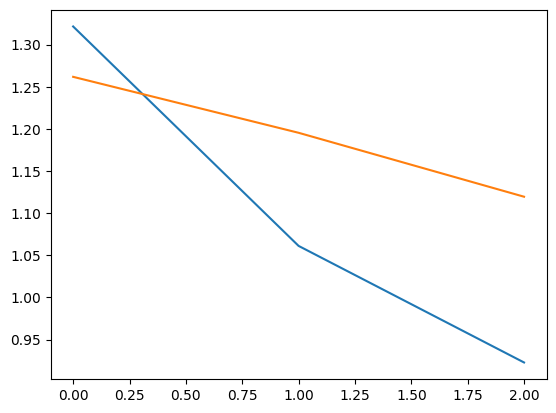

In [78]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(3)],tr_loss_l)
plt.plot([i for i in range(3)],val_loss_l)
plt.show()

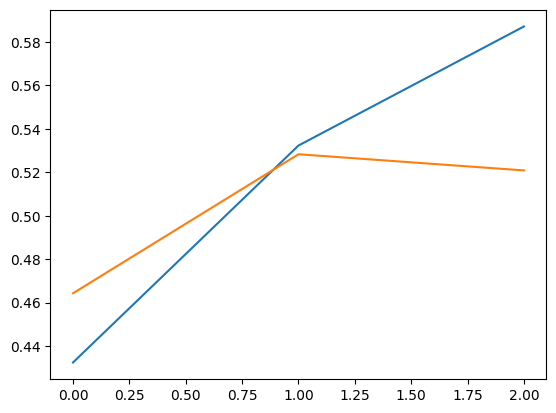

In [79]:
plt.plot([i for i in range(3)],tr_acc_l)
plt.plot([i for i in range(3)],val_acc_l)
plt.show()

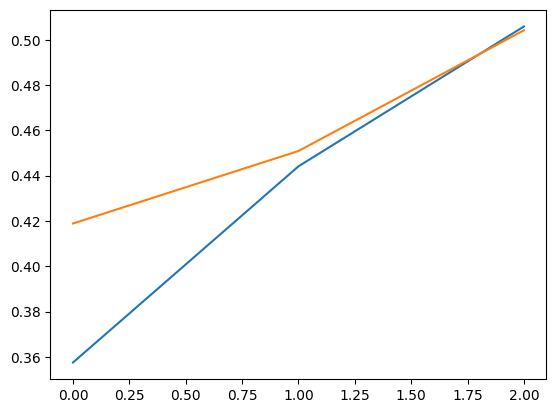

In [80]:
plt.plot([i for i in range(3)],tr_prec_l)
plt.plot([i for i in range(3)],val_prec_l)
plt.show()

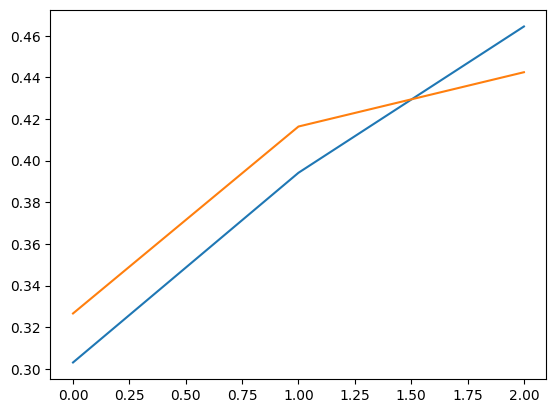

In [81]:
plt.plot([i for i in range(3)],tr_f1_l)
plt.plot([i for i in range(3)],val_f1_l)
plt.show()

In [86]:
from sklearn.model_selection import train_test_split
train_data=os.listdir("/content/drive/MyDrive/DL_project/TEST")
train_data.sort()
train_data_2=[0,0,0,0,0]
train_data_2[0]=train_data[1]
train_data_2[1]=train_data[2]
train_data_2[2]=train_data[0]
train_data_2[3]=train_data[4]
train_data_2[4]=train_data[3]
all_paths=[]
all_labels=[]
for i,path in enumerate(train_data_2):
    full_path="/content/drive/MyDrive/DL_project/TEST/"+path+"/"
    lst=os.listdir(full_path)
    lst=[full_path+i for i in lst]
    all_paths.extend(lst)
    all_labels.extend([i for j in range(len(lst))])
all_paths=np.array(all_paths)
all_labels=np.array(all_labels)

In [87]:
test_dataset=DataSet2(all_paths,all_labels,trans)
test_loader=DataLoader(test_dataset,batch_size=12,shuffle=True)

110it [12:54,  7.04s/it]


Testing ,Running Loss 1.0727346628904342 ,Accuracy:0.6393939393939392,Precision:0.4674790764790764,F1:0.4502988607747965


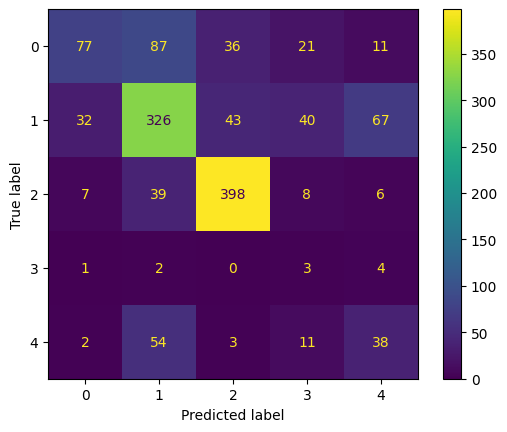

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()
with torch.no_grad():
    total_loss = 0
    test_acc=0
    test_prec=0
    test_f1=0
    testing_pred=None
    testing_out=None
    for i,(inputs, targets) in tqdm(enumerate(test_loader)):
        outputs = model(inputs)
        targets=targets.to(torch.long)
        targets=targets.to('cpu')
        outputs=outputs.to('cpu')
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        outputs=torch.argmax(outputs,dim=1)
        test_acc+=get_acc(outputs,targets)
        test_prec+=get_prec(outputs,targets)
        test_f1+=get_f1(outputs,targets)
        if(testing_pred is None):
            testing_pred=np.array(outputs)
            testing_out=np.array(targets)
        else:
            testing_pred=np.concatenate([testing_pred,np.array(outputs)],axis=0)
            testing_out=np.concatenate([testing_out,np.array(targets)],axis=0)        
    test_acc/=(i+1)
    total_loss/=(i+1)
    test_prec/=(i+1)
    test_f1/=(i+1)
    sen = f"Testing ,Running Loss {total_loss} ,Accuracy:{test_acc},Precision:{test_prec},F1:{test_f1}"
    print(sen)
    cm = confusion_matrix(testing_out,testing_pred, labels=[i for i in range(5)])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[i for i in range(5)])
    disp.plot()
    plt.show()

In [89]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(testing_out,testing_pred)
print("Kappa score:", kappa)

Kappa score: 0.4852868126735902
